In [52]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

In [53]:
train=pd.read_csv('train.csv')

# House price regression using TensorFlow

I have to: 

1) load the data

2) apply some basic feature engineering and cleaning

3) encode and normalize the data into something that can be efficiently computed by tensorflow

4) train the model, score it and compute metrics

5) check the model predictions visually

6) predict the house prices in the test set

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

https://www.tensorflow.org/tutorials/load_data/csv

https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers?authuser=2

In [54]:
from house_prices import feat_eng

In [55]:
int_cat_f=['SaleCondition','ExterQual','Neighborhood','KitchenQual','SaleType','PoolQC']
int_num_f=['OverallQual','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea','GarageArea','YearBuilt']
int_ord_f=['GarageCars','TotRmsAbvGrd']

First implementation: only using numeric features and model.fit() method

In [56]:
label='SalePrice'


In [57]:
#
x,y=train.drop(label,axis=1),train[label]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [58]:
train_num_feat,test_num_feat=x_train[int_num_f],x_test[int_num_f]
tf.convert_to_tensor(train_num_feat)
tf.convert_to_tensor(test_num_feat)
tf.convert_to_tensor(y_test)
tf.convert_to_tensor(y_train)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_num_feat)


In [59]:
print(x_test)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
529    530          20       RL          NaN    32668   Pave   NaN      IR1   
491    492          50       RL         79.0     9490   Pave   NaN      Reg   
459    460          50       RL          NaN     7015   Pave   NaN      IR1   
279    280          60       RL         83.0    10005   Pave   NaN      Reg   
655    656         160       RM         21.0     1680   Pave   NaN      Reg   
...    ...         ...      ...          ...      ...    ...   ...      ...   
271    272          20       RL         73.0    39104   Pave   NaN      IR1   
445    446          20       RL         73.0     9855   Pave   NaN      Reg   
654    655          20       RL         91.0    10437   Pave   NaN      IR1   
1280  1281          20       RL         67.0     9808   Pave   NaN      IR1   
898    899          20       RL        100.0    12919   Pave   NaN      IR1   

     LandContour Utilities  ... ScreenPorch PoolAre

In [60]:
print(normalizer(train_num_feat))

tf.Tensor(
[[ 0.67840314 -0.11597695  0.6906337  ...  0.98899615  0.84137374
   0.8621176 ]
 [-0.05839539 -0.74672246  1.3049937  ... -0.44659436 -0.18397988
   0.82903516]
 [-0.7951939  -0.32674396  0.59056747 ... -1.2832171  -2.2490613
  -0.42809662]
 ...
 [-0.05839539 -0.15923864 -1.029109   ...  0.7339518   0.33348832
   0.23355168]
 [ 0.67840314 -0.7166824  -1.029109   ...  0.06735864 -0.23668498
   1.0606121 ]
 [ 0.67840314  0.6029446  -1.029109   ...  0.61222607  0.07954558
   0.89519995]], shape=(1022, 7), dtype=float32)


https://www.tensorflow.org/guide/keras/preprocessing_layers

In [61]:
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics='mean_squared_error')
  return model

In [62]:
model= get_basic_model()
history=model.fit(train_num_feat, y_train, epochs=300, batch_size=15,validation_data=(test_num_feat,y_test))


Epoch 1/300
69/69 [==============================] - 1s 12ms/step - loss: 98.1399 - mean_squared_error: 38705287168.0000 - val_loss: 66.4113 - val_mean_squared_error: 39784390656.0000
Epoch 2/300
69/69 [==============================] - 1s 9ms/step - loss: 53.5605 - mean_squared_error: 38659313664.0000 - val_loss: 42.6266 - val_mean_squared_error: 39700082688.0000
Epoch 3/300
69/69 [==============================] - 1s 9ms/step - loss: 36.8447 - mean_squared_error: 38542176256.0000 - val_loss: 31.1975 - val_mean_squared_error: 39536320512.0000
Epoch 4/300
69/69 [==============================] - 1s 8ms/step - loss: 27.9030 - mean_squared_error: 38351863808.0000 - val_loss: 24.2851 - val_mean_squared_error: 39287119872.0000
Epoch 5/300
69/69 [==============================] - 1s 8ms/step - loss: 22.1649 - mean_squared_error: 38073864192.0000 - val_loss: 19.5689 - val_mean_squared_error: 38948229120.0000
Epoch 6/300
69/69 [==============================] - 1s 8ms/step - loss: 18.0568 - m

In [63]:
predictions=model.predict(test_num_feat)

14/14 [==============================] - 0s 3ms/step


In [64]:
print(y_test)

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
271     241500
445     127500
654     350000
1280    227000
898     611657
Name: SalePrice, Length: 438, dtype: int64


In [65]:
from sklearn.metrics import mean_squared_log_error, r2_score

In [66]:
def score_and_visualize(model,x_test,y_test):
    predictions=model.predict(x_test)
    plt.figure(figsize=(10,10))
    plt.scatter(y_test,predictions)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    msle=mean_squared_log_error(y_true=y_test, y_pred=predictions)#msle is the metric evaluated in the kaggle challange
    r2=r2_score(y_true=y_test, y_pred=predictions)
    print('r2 coefficient: ',r2,'\nmsle = ', msle)
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.axline((0,0),slope=1,ls='--')
    plt.show()

14/14 [==============================] - 0s 4ms/step
r2 coefficient:  0.686427068148008 
msle =  0.02729603789643293


ValueError: Polynomial must be 1d only.

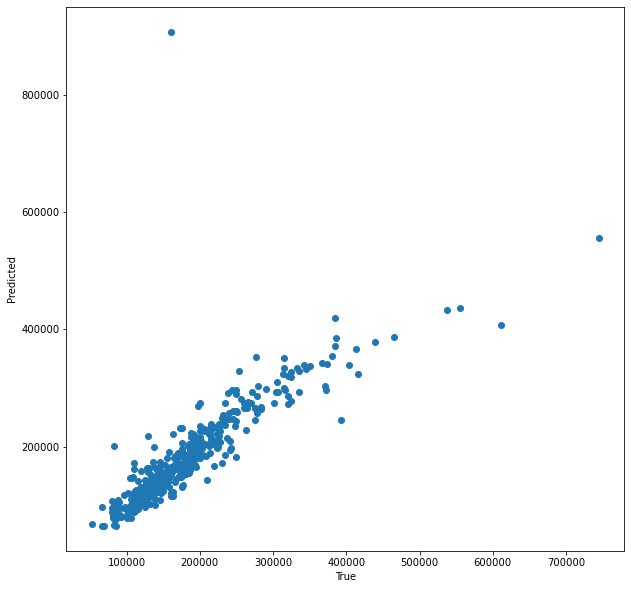

In [68]:
score_and_visualize(model=model,x_test=test_num_feat,y_test=y_test)


In [69]:
test=pd.read_csv('test.csv')
test=test[int_num_f]
tf.convert_to_tensor(test)
pred=model.predict(test)
write=True
out_df=pd.read_csv('sample_submission.csv')
out_df['SalePrice']=pred
if write:
    out_df.to_csv('prediction_tf.csv',index=False)

46/46 [==============================] - 0s 3ms/step
